In [1]:
%matplotlib inline


# Comparison of Calibration of Classifiers


Well calibrated classifiers are probabilistic classifiers for which the output
of the predict_proba method can be directly interpreted as a confidence level.
For instance a well calibrated (binary) classifier should classify the samples
such that among the samples to which it gave a predict_proba value close to
0.8, approx. 80% actually belong to the positive class.

LogisticRegression returns well calibrated predictions as it directly
optimizes log-loss. In contrast, the other methods return biased probabilities,
with different biases per method:

* GaussianNaiveBayes tends to push probabilities to 0 or 1 (note the counts in
  the histograms). This is mainly because it makes the assumption that features
  are conditionally independent given the class, which is not the case in this
  dataset which contains 2 redundant features.

* RandomForestClassifier shows the opposite behavior: the histograms show
  peaks at approx. 0.2 and 0.9 probability, while probabilities close to 0 or 1
  are very rare. An explanation for this is given by Niculescu-Mizil and Caruana
  [1]_: "Methods such as bagging and random forests that average predictions
  from a base set of models can have difficulty making predictions near 0 and 1
  because variance in the underlying base models will bias predictions that
  should be near zero or one away from these values. Because predictions are
  restricted to the interval [0,1], errors caused by variance tend to be one-
  sided near zero and one. For example, if a model should predict p = 0 for a
  case, the only way bagging can achieve this is if all bagged trees predict
  zero. If we add noise to the trees that bagging is averaging over, this noise
  will cause some trees to predict values larger than 0 for this case, thus
  moving the average prediction of the bagged ensemble away from 0. We observe
  this effect most strongly with random forests because the base-level trees
  trained with random forests have relatively high variance due to feature
  subsetting." As a result, the calibration curve shows a characteristic
  sigmoid shape, indicating that the classifier could trust its "intuition"
  more and return probabilities closer to 0 or 1 typically.

* Support Vector Classification (SVC) shows an even more sigmoid curve as
  the  RandomForestClassifier, which is typical for maximum-margin methods
  (compare Niculescu-Mizil and Caruana [1]_), which focus on hard samples
  that are close to the decision boundary (the support vectors).

.. topic:: References:

    .. [1] Predicting Good Probabilities with Supervised Learning,
          A. Niculescu-Mizil & R. Caruana, ICML 2005


In [2]:
print(__doc__)

# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)

train_samples = 100  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()


# #############################################################################
# Plot calibration plots



Automatically created module for IPython interactive environment


In [3]:
y_test

array([0, 1, 1, ..., 0, 0, 1])

In [6]:
prob_pos

array([0.17, 0.84, 0.91, ..., 0.38, 0.54, 0.84])

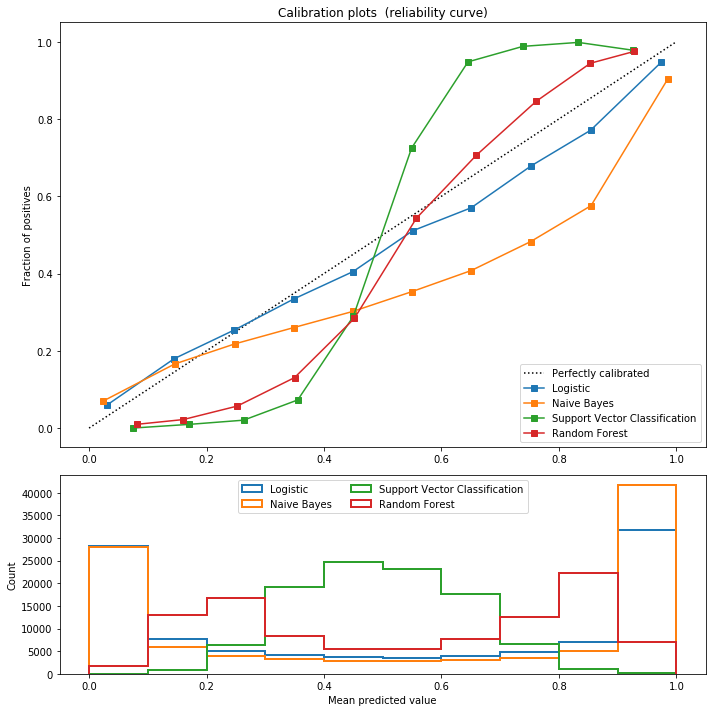

In [5]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value =  calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()